# PyEumap - Land-Cover Mapping (Advanced)

In this tutorial we improve the land cover mapping through a hyperparameter optimization and present some alternative to produce probability outputs using the eumap library. Before continue, please, first execute the [Overlay Demonstration](02_overlay.ipynb) and [Land-Cover Mapping](03_landcover_mapping.ipynb) tutorials for the same tile.

First, let's import the necessary modules

In [1]:
import sys
sys.path.append('../../')

import os
import gdal
from pathlib import Path
import pandas as pd
import geopandas as gpd
from pyeumap.mapper import LandMapper

...and load the overlayed samples for a specific tile:

In [2]:
from pyeumap import datasets

# Tile definition
tile = datasets.TILES[0]
print(f'Tile: {tile}\n\n')

# Folder setup
data_root = datasets.DATA_ROOT_NAME
data_dir = Path(os.getcwd()).joinpath(data_root,tile)

# Reading the samples
fn_points = Path(os.getcwd()).joinpath(data_dir, tile + '_landcover_samples_overlayed.gpkg')
points = gpd.read_file(fn_points)
points.head()

Tile: 10636_switzerland




,lucas,survey_date,confidence,tile_id,lc_class,overlay_id,dtm_elevation,dtm_slope,landsat_ard_fall_thermal_p25,landsat_ard_summer_thermal_p50,...,landsat_ard_winter_red_p25,landsat_ard_spring_blue_p75,landsat_ard_winter_swir1_p25,landsat_ard_fall_swir2_p25,landsat_ard_spring_green_p75,landsat_ard_winter_nir_p50,landsat_ard_fall_green_p25,landsat_ard_spring_nir_p25,landsat_ard_summer_swir1_p75,geometry
0,False,2006-06-30T00:00:00,85,10636,321,1,1948.0,36.313705,184.0,183.0,...,147.0,11.0,16.0,30.0,19.0,181.0,16.0,83.0,57.0,POINT (4145221.759 2594636.440)
1,False,2006-06-30T00:00:00,85,10636,321,2,2209.0,7.917305,182.0,182.0,...,132.0,144.0,33.0,31.0,159.0,171.0,17.0,120.0,49.0,POINT (4142366.664 2598169.380)
2,False,2006-06-30T00:00:00,85,10636,321,3,1990.0,32.722038,187.0,185.0,...,119.0,10.0,26.0,28.0,19.0,179.0,12.0,62.0,57.0,POINT (4140249.007 2596954.755)
3,False,2006-06-30T00:00:00,85,10636,322,4,2142.0,49.800537,178.0,179.0,...,41.0,37.0,7.0,6.0,36.0,63.0,4.0,55.0,23.0,POINT (4148638.412 2595538.585)
4,False,2006-06-30T00:00:00,85,10636,332,5,2420.0,27.018671,188.0,188.0,...,235.0,214.0,13.0,54.0,221.0,229.0,29.0,172.0,85.0,POINT (4156286.754 2595790.720)


# Hyperparameter optimization

The eumap library supports hyperparameter optimization for hard and soft land-cover classifications. In a hard classification each pixel can have a unique class associate as land-cover, and the prediction output is one single raster with the lc-class. On the other hand, using a soft classification it's possible associate multiple lc-class for a sinle pixel, and the prediction output are several raster files (one raster per class).

## Hard classification

In the past [Land-Cover tutorial](03_landcover_mapping.ipynb) we execute a Random Forest classifier with a predefined set of hyperparameters (n_estimators=100). Now it's time to evaluate other possibilties using a [grid search](https://scikit-learn.org/0.17/modules/grid_search.html#grid-search) and evaluating the results with a cross validation strategy ([K-Fold](https://medium.com/datadriveninvestor/k-fold-cross-validation-6b8518070833)). 

In [3]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_leaf': [1, 10],
    'max_depth': [15, None],
    'max_features': ['sqrt', 0.5],
    'class_weight': ['balanced', None]
}

To find the best hyperparameters the optimization process should use a evaluation metric as reference. In this example we will use the [f1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), that is basically a weighted average between the [precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score) and [recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score). It's possible use other [evaluation metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) modifing ou creating a new python function, that will be passed as parameter for the LandMapper class.

In the remote sensing area the precision was renamed to Producer's Accuracy (the producer of the classification is interested in understand how well a specific area on Earth can be mapped) and the recall was renamed to User's Accuracy (the user of classification is interested in check how well the map represents what is really on the ground) ([Story, 1986](https://www.asprs.org/wp-content/uploads/pers/1986journal/mar/1986_mar_397-399.pdf)).

In [4]:
from sklearn.metrics import f1_score

def f1_scorer(clf, X, y_true):
    y_pred = clf.predict(X)
    error = f1_score(y_true, y_pred, average='weighted')
    return error

The evaluation metric will be calculated using a cross validation strategy, using diferente parts of samples to train and validate the model. Here we will use a 5-fold cv, but others [validation strategies](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) are also supported by LandMapper class.

In [5]:
from sklearn.model_selection import KFold

eval_strategy = 'grid_search_cv'
cv_kfold = KFold(5)

Now let's instantiate the LandMapper class using the follow parameters:
* *fn_points*: the geopackage filepath or [GeoPandas DataFrame](https://geopandas.org/reference/geopandas.GeoDataFrame.html) instance
* *feat_col_prfxs*: the prefix of all columns that should be included as covariates in the feature space 
* *target_col*: the name of the column that should be considered as the target variable by the model
* *estimator*: The model implementation, which could be any one available in the [sklearn](https://scikit-learn.org/stable/modules/classes.html) 
* ***param_grid***: The hyperparameters possibilities defined previously
* *val_samples*: The sample proportion that should be used by validation
* ***scoring***: A python function responsable to calculate the evaluation metric
* ***eval_strategy***: Here pass 'grid_search_cv' to execute the the hyperparameter optimization
* *min_samples_per_class*: The minimum sample proportion per class. For example, all the classes with less than 5% of samples will be removed from the training
* ***weight_col***: The name of the column with the weight values for each samples. In our case, it's the *confidence* column generated by harmonization process of [LUCAS and CORINE samples](https://zenodo.org/record/4311598#.X9x-Vtm2L0o)
* ***verbose***: If True will show the progress/debug information. Use it to visualize the best hyperparameters that will be found

In [6]:
feat_col_prfxs = ['landsat', 'dtm', 'night_lights']
target_col = 'lc_class'
weight_col = 'confidence'

landmapper = LandMapper(fn_points, feat_col_prfxs, target_col, 
                        estimator = estimator, param_grid=param_grid,
                        min_samples_per_class=0.05, scoring=f1_scorer,
                        eval_strategy=eval_strategy, cv=cv_kfold,
                        verbose = True, weight_col=weight_col)

[11:03:01] Using 87 features from dataset
[11:03:01] Removing 74 sampes due min_samples_per_class condition (< 0.05)
[11:03:01] Using confidence as weight


Time to start the optimization process. 

**If it's taking too long try to reduce the hyperparameters possibilities and/or the k-fold cv (2-fold).**

In [7]:
landmapper.train()

[11:03:01] Training and evaluating the model
[11:03:01] Finding the best hyperparameters dict_keys(['min_samples_leaf', 'max_depth', 'max_features', 'class_weight'])
[11:03:01] Using 1 jobs for cross validation
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[11:03:24] Hyperparameter optimization result:
[11:03:24]  -0.69425 (+/-0.07407) from {'class_weight': 'balanced', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1}
[11:03:24]  -0.62387 (+/-0.09070) from {'class_weight': 'balanced', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 10}
[11:03:24]  -0.70740 (+/-0.06248) from {'class_weight': 'balanced', 'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 1}
[11:03:24]  -0.65500 (+/-0.05999) from {'class_weight': 'balanced', 'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 10}
[11:03:24]  -0.69043 (+/-0.08384) from {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1}
[11:03:24]  -0.63511 (+/-0.09292) from {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10}
[11:03:24]  -0.71033 (+/-0.07477) from {'class_weight': 'balanced', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1}
[11:03:24]  -0.65847 (+/-0.07

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   23.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[11:03:26] Training the final model using all data


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished


Let's understand what happened here:
1. Diferent combinations of hyperparameters where evaluated
2. The best one was chosen and all the samples were cross validated to derive other classification metrics
3. A final model were trained using all the samples, without cv. This model will be used to classify the land-cover in future prediction

We can check other classification metrics for the best classification models

In [8]:
print(f'Overall accuracy: {landmapper.overall_acc * 100:.2f}%\n\n')
print(landmapper.classification_report)

Overall accuracy: 71.71%


              precision    recall  f1-score   support

       231.0       0.79      0.73      0.76        66
       312.0       0.67      0.78      0.72       199
       321.0       0.70      0.72      0.71       166
       322.0       0.56      0.53      0.55       116
       324.0       0.35      0.19      0.25        84
       332.0       0.81      0.70      0.75       101
       333.0       0.78      0.84      0.81       229
       335.0       0.95      0.99      0.97        89

    accuracy                           0.72      1050
   macro avg       0.70      0.69      0.69      1050
weighted avg       0.70      0.72      0.71      1050



... or the complete confusion matrix:

In [9]:
landmapper.cm

array([[ 48,   5,  11,   0,   1,   0,   1,   0],
       [  1, 155,   9,  18,  16,   0,   0,   0],
       [  8,   9, 120,  10,   5,   0,  14,   0],
       [  0,  20,  15,  62,   7,   1,  10,   1],
       [  4,  40,  11,  10,  16,   0,   3,   0],
       [  0,   0,   0,   0,   0,  71,  26,   4],
       [  0,   3,   6,  11,   1,  15, 193,   0],
       [  0,   0,   0,   0,   0,   1,   0,  88]])

You can also can access the raw cv results:

In [10]:
pd.DataFrame({
    'Expected LC-class':landmapper.eval_targ,
    'Predict LC-class': landmapper.eval_pred}
)

,Expected LC-class,Predict LC-class
0,321.0,321.0
1,321.0,321.0
2,321.0,321.0
3,322.0,322.0
4,332.0,333.0
...,...,...
1045,312.0,312.0
1046,332.0,333.0
1047,321.0,321.0
1048,333.0,333.0


## Soft Classification

For a soft classification the hyperparameter optimization should use a diferent evaluation metric, appropiate for probabilities output per class. For this tutorial we choosen [log_loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) (logistic loss or cross-entropy loss). 

Unlike the F1-Score, a lower log_loss is better for the optimization process, and because of that we will multiply by -1 the final error.

In [11]:
from sklearn.metrics import log_loss

def log_loss_scorer(clf, X, y_true):
    class_labels = clf.classes_
    y_pred_proba = clf.predict_proba(X)
    error = log_loss(y_true, y_pred_proba, labels=class_labels)
    return error * -1

We will use the same classification algorithm, hyperparameter possibilities and cv strategy:

In [12]:
prob_estimator = RandomForestClassifier(n_jobs=-1)

prob_param_grid = {
    'min_samples_leaf': [1, 5],
    'max_depth': [5, None],
    'max_features': ['sqrt', 0.5],
    'class_weight': ['balanced', None]
}

prob_eval_strategy = 'grid_search_cv'
prob_cv_kfold = KFold(5)

Now let's create a new instance for the LandMapper class passing one aditional parameter:
* ***pred_method***: The predict_proba will change the model output for a lc-class probabilities.

In [13]:
feat_col_prfxs = ['landsat', 'dtm', 'night_lights']
target_col = 'lc_class'
weight_col = 'confidence'

landmapper_prob = LandMapper(fn_points, feat_col_prfxs, target_col, 
                        estimator = prob_estimator, param_grid = prob_param_grid,
                        min_samples_per_class=0.05, scoring=log_loss_scorer, pred_method='predict_proba',
                        eval_strategy=prob_eval_strategy, cv=prob_cv_kfold,
                        verbose = True, weight_col=weight_col)

[11:03:26] Using 87 features from dataset
[11:03:26] Removing 74 sampes due min_samples_per_class condition (< 0.05)
[11:03:26] Using confidence as weight


Let's run it again.

**If it's taking too long try to reduce the hyperparameters possibilities and/or the k-fold cv (2-fold).**

In [14]:
landmapper_prob.train()

[11:03:27] Training and evaluating the model
[11:03:27] Finding the best hyperparameters dict_keys(['min_samples_leaf', 'max_depth', 'max_features', 'class_weight'])
[11:03:27] Using 1 jobs for cross validation
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[11:03:48] Hyperparameter optimization result:
[11:03:48]  1.14314 (+/-0.06524) from {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1}
[11:03:48]  1.14810 (+/-0.08354) from {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5}
[11:03:48]  1.08459 (+/-0.05842) from {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 1}
[11:03:48]  1.08992 (+/-0.06992) from {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 5}
[11:03:48]  0.86293 (+/-0.17417) from {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1}
[11:03:48]  0.95098 (+/-0.10253) from {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5}
[11:03:48]  0.82299 (+/-0.16729) from {'class_weight': 'balanced', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1}
[11:03:48]  0.88928 (+/-0.09802) from {'cla

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   21.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[11:03:49] Training the final model using all data


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished


Now let's take a look in the classification report.

In [15]:
print(landmapper_prob.classification_report)

     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

231  0.8172     0.8122   0.3500        0.7273              0.7273         66
312  0.6662     0.7789   0.4200        0.7085              0.7121         199
321  1.0283     0.7987   0.3600        0.7229              0.7101         166
322  1.2902     0.5163   0.3200        0.5776              0.5726         116
324  2.1142     0.2832   0.2900        0.3571              0.3614         84
332  0.6938     0.7930   0.3800        0.7426              0.7426         101
333  0.5558     0.8723   0.4300        0.7991              0.7957         229
335  0.1462     0.9805   0.5200        0.9663              0.9663         89

Total                                                                     1050



Let's understand this report.

Using the cv result the LandMapper calculated the [log_loss]() and the pr_auc [(area under the precision recall curve)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve) for each class. The pr_auc information was used to choosen the best probability value to derive a hard classification output, balancing the precision (producer's accuracy or the class understimation) and recall (user's accuracy or the class overestimation), thus minimizing the bias in the land-cover area estimation using the final maps. For more infomation about the precision recall curve [access this link](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/).

All the probabilities metrics are available through the *prob_metrics* property

In [16]:
list(landmapper_prob.prob_metrics.keys())

['log_loss',
 'pr_auc',
 'support',
 'opti_th',
 'opti_recall',
 'opti_precision',
 'curv_recall',
 'curv_precision',
 'curv_th']

...and it's possible to use the raw cv results to derive other evaluation metrics as [hinge_loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hinge_loss.html):

In [17]:
from sklearn import metrics
metrics.hinge_loss(landmapper_prob.eval_targ, landmapper_prob.eval_pred)

0.7184714315615061

# Emsemble Machine Learning and Uncertainty Estimation

Now we will construct a stacked classifier ensemble using [`ml-ens`](http://ml-ensemble.com/) and train it on our data in an equivalent manner to training a single model.

In [18]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from mlens.ensemble import SuperLearner

feat_col_prfxs = ['landsat', 'dtm', 'night_lights']
target_col = 'lc_class'

stacked_ensemble = SuperLearner()
stacked_ensemble.add([
    RandomForestClassifier(),
    SVC(probability=True),
    KNeighborsClassifier(),
], proba=True)
stacked_ensemble.add_meta(GradientBoostingClassifier())

landmapper = LandMapper(
    fn_points, feat_col_prfxs, target_col,
    estimator=stacked_ensemble,
    val_samples_pct=0.5,
    min_samples_per_class=0.05,
    verbose=False
)

landmapper.train()
print(f'Overall accuracy: {landmapper.overall_acc * 100:.2f}%\n\n')
print(landmapper.classification_report)

[MLENS] backend: threading


Overall accuracy: 61.14%


              precision    recall  f1-score   support

       231.0       0.37      0.78      0.50        37
       312.0       0.68      0.72      0.70       101
       321.0       0.54      0.54      0.54        84
       322.0       0.46      0.37      0.41        51
       324.0       0.43      0.15      0.22        41
       332.0       0.70      0.57      0.63        54
       333.0       0.70      0.69      0.70       113
       335.0       0.87      0.91      0.89        44

    accuracy                           0.61       525
   macro avg       0.60      0.59      0.57       525
weighted avg       0.62      0.61      0.60       525



Next, we will construct a voting classifier ensemble using [`scikit-learn`](https://scikit-learn.org) and train it.

In [19]:
voting_ensemble = VotingClassifier([
    ('rf', RandomForestClassifier()),
    ('svm', SVC(probability=True)),
    ('knn', KNeighborsClassifier()),
    ('gbt', GradientBoostingClassifier()),
], voting='soft')

landmapper = LandMapper(
    fn_points, feat_col_prfxs, target_col,
    estimator=voting_ensemble,
    val_samples_pct=0.5,
    min_samples_per_class=0.05,
    verbose=False
)

landmapper.train()
print(f'Overall accuracy: {landmapper.overall_acc * 100:.2f}%\n\n')
print(landmapper.classification_report)

Overall accuracy: 67.81%


              precision    recall  f1-score   support

       231.0       0.90      0.79      0.84        34
       312.0       0.65      0.78      0.71        97
       321.0       0.64      0.65      0.65        86
       322.0       0.48      0.55      0.51        53
       324.0       0.67      0.31      0.42        45
       332.0       0.88      0.40      0.55        58
       333.0       0.70      0.82      0.76       116
       335.0       0.73      1.00      0.85        36

    accuracy                           0.68       525
   macro avg       0.71      0.66      0.66       525
weighted avg       0.69      0.68      0.67       525



With our second ensemble model we will produce predictions over the sample tile, as well as a classification uncertainty estimate.

In [20]:
data_root = datasets.DATA_ROOT_NAME
data_dir = Path(os.getcwd()).joinpath(data_root, tile)

dir_timeless_layers = os.path.join(data_dir, 'timeless')
dir_2000_layers = os.path.join(data_dir, '2000')

dirs_layers = [dir_2000_layers, dir_timeless_layers]
fn_result = 'land_cover_2000.tif'
data_type = gdal.GDT_Int16

landmapper.predict(dirs_layers, fn_result, data_type, estimate_uncertainty=True)

Now we can visualize our predictions and uncertainty with the `pyeumap.plotter` module.

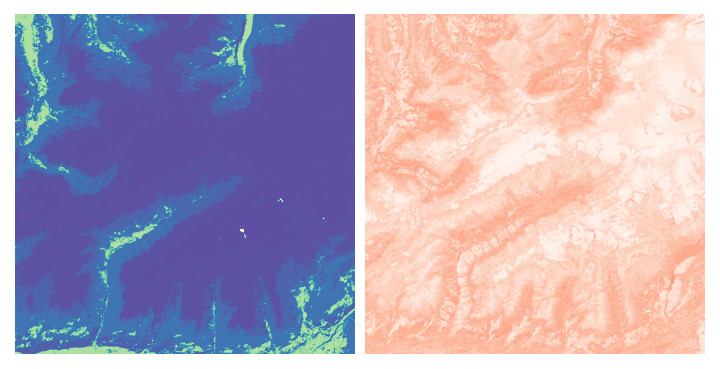

In [21]:
from pyeumap import plotter

plotter.plot_rasters(
    'land_cover_2000.tif',
    'land_cover_2000_uncertainty.tif',
    cmaps=['Spectral', 'Reds'],
    figsize=6,
)

The image on the right represents classification uncertainty (ranging from 0 - white to 100 - red), expressed as relative entropy of the class predictions (the ratio of the prediction entropy to the maximum possible entropy for the given number of classes).